In [1]:
# %%

import site
import sys

site.addsitedir('../')  # Always appends to end

from kan import *
import numpy as np
import torch
import matplotlib.pyplot as plt
import pdb


In [2]:
# %%
import math
from torch.utils.data import Dataset

# f = lambda x: (x[:,[0]]**2 + x[:,[2]] + 3*torch.sin(x[:,[1]]))/(x[:,[0]] + 2*x[:,[1]] - x[:,[2]])
# sin(x) * cos(y) + exp(z/2) - x^2 * y
f = lambda x: torch.sin(x[:, [0]]) * torch.cos(x[:, [1]]) + torch.exp(x[:, [2]]/2) - x[:, [0]]**2 * x[:, [1]]

# trainpoints = int((5/0.05)**3)
trainpoints = 20000
testpoints = trainpoints//5

trainpoints_subtask = trainpoints // 5
testpoints_subtask = testpoints // 5
pruning_threshold = 0.05

datasetall = create_dataset(f, n_var=3, train_num=trainpoints, test_num=testpoints, seed=0, ranges=[[-5, 5], [-5, 5], [-5, 5]])
datasetoct0 = create_dataset(f, n_var=3, train_num=trainpoints_subtask, test_num=testpoints_subtask, seed=0, ranges=[[-5, 0], [-5, 0], [-5, 0]])


 ## build KAN architecture

 Training KAN

In [3]:
# %%
# setting bias_trainable=False, sp_trainable=False, sb_trainable=False is important.
# otherwise KAN will have random scaling and shift for samples in previous stages

model = KAN(width=[3,5,1], grid=5, k=3, sp_trainable=False, sb_trainable=False, noise_scale=0.1, device="cpu")
# make a 3D tensor with 5 points in each dimension
x = torch.linspace(-5, 5, steps=11).repeat(3, 1).T

model.update_grid_from_samples(x)
# model = KAN(width=[3,5,1], grid=5, k=3, noise_scale=0.1, device="cpu")
# model.train(datasetoct0, opt = 'Adam', steps=5000, update_grid=False, device="cuda", lr=0.02);
model.train(datasetoct0, opt="LBFGS", steps=80);

train loss: 9.23e-02 | test loss: 1.00e-01 | reg: 3.23e+01 : 100%|██| 80/80 [01:48<00:00,  1.35s/it]


In [4]:
f_pred = model(datasetoct0['test_input'].to('cpu')).to('cpu').detach().numpy()

In [5]:
f_true = datasetoct0['test_label'].to('cpu').detach().numpy()

In [6]:
# compute R^2 between prediction and true value
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

R^2: 0.9999897634188528
R^2 of total dataset: 0.1587788462638855


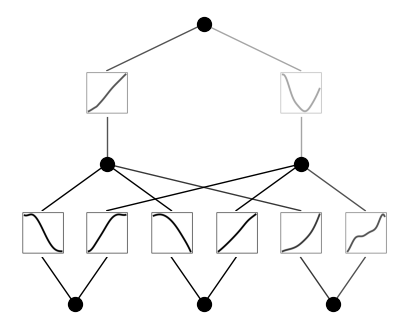

In [7]:
model = model.prune(threshold=0.1)
model(datasetoct0['train_input'].to("cpu"))
model.plot()

## retrain network using such model and see

In [8]:
# model.train(datasetoct0, opt = 'Adam', steps=5000, update_grid=False, device="cuda", lr=0.02);
model.train(datasetoct0, opt="LBFGS", steps=80);
f_pred = model(datasetoct0['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct0['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

train loss: 2.25e-01 | test loss: 2.42e-01 | reg: 1.49e+01 : 100%|██| 80/80 [00:48<00:00,  1.63it/s]

R^2: 0.9999402495777758
R^2 of total dataset: -0.06917226314544678


## looks good, as R^2 > 0.95. We will use the network for the next dataset

In [9]:
datasetoct1 = create_dataset(f, n_var=3, train_num=trainpoints_subtask, test_num=testpoints_subtask, seed=0, ranges=[[-5, 0], [-5, 0], [0, 5]])

### freeze/slow down/regularize/stop early network and determine nodes that is the opposite of pruning

In [10]:
# model.train(datasetoct1, opt = 'Adam', steps=5000, update_grid=False, device="cuda", lr=lr_half);

In [11]:
model.train(datasetoct1, opt="LBFGS", steps=int(80/2));
f_pred = model(datasetoct1['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct1['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetoct0['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct0['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of datasetoct0: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

train loss: 2.13e-01 | test loss: 2.23e-01 | reg: 1.55e+01 : 100%|██| 40/40 [00:21<00:00,  1.86it/s]

R^2: 0.9999581105221296
R^2 of datasetoct0: 0.9855069778859615
R^2 of total dataset: 0.12102442979812622


Also total dataset has bad r^2. Lack of data?   
Less catastrophic forgetting PROVIDED that the network is well pruned. Occam's Razor?

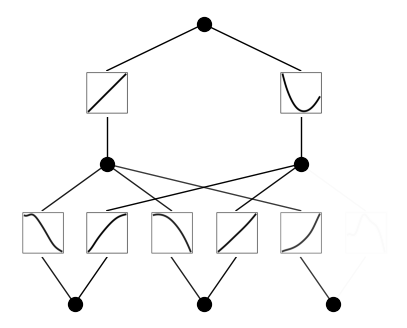

In [12]:
model = model.prune(threshold=pruning_threshold)
model(datasetoct1['train_input'].to("cpu"))
model.plot()

In [31]:
datasetoct2 = create_dataset(f, n_var=3, train_num=trainpoints_subtask, test_num=testpoints_subtask, seed=0, ranges=[[-5, 0], [0, 5], [-5, 0]])
# model.train(datasetoct2, opt="LBFGS", steps=int(80/3));
model = model_bk
model.train(datasetoct2, opt="LBFGS", steps=1);
f_pred = model(datasetoct2['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct2['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetoct1['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct1['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of datasetoct1: {r2}")

f_pred = model(datasetoct0['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct0['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of datasetoct0: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

description:   0%|                                                            | 0/1 [00:00<?, ?it/s]

train loss: 2.16e+00 | test loss: 2.21e+00 | reg: 3.58e+01 : 100%|████| 1/1 [00:05<00:00,  5.27s/it]

R^2: 0.9953706306405365
R^2 of datasetoct1: 0.02042984962463379
R^2 of datasetoct0: -0.1959477663040161
R^2 of total dataset: -0.4903475046157837


A single iteration of LBFGS causes immediate catastrophic forgetting. Also, repeated dataset creation greatly varies r^2. Dataset quality is the problem.

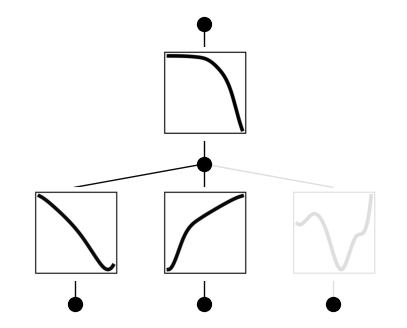

In [14]:
model = model.prune(threshold=pruning_threshold)
model(datasetoct2['train_input'].to("cpu"))
model.plot()

In [15]:
datasetoct3 = create_dataset(f, n_var=3, train_num=trainpoints_subtask, test_num=testpoints_subtask, seed=0, ranges=[[-5, 0], [0, 5], [0, 5]])
model.train(datasetoct3, opt="LBFGS", steps=int(80/4));
f_pred = model(datasetoct3['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct3['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

train loss: 2.53e+00 | test loss: 2.52e+00 | reg: 5.12e+00 : 100%|██| 20/20 [01:08<00:00,  3.41s/it]

R^2: 0.9928696481510997
R^2 of total dataset: -4.074105739593506


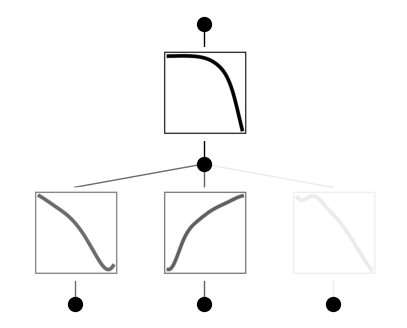

In [16]:
model = model.prune(threshold=pruning_threshold)
model(datasetoct3['train_input'].to("cpu"))
model.plot()

In [17]:
datasetoct4 = create_dataset(f, n_var=3, train_num=trainpoints_subtask, test_num=testpoints_subtask, seed=0, ranges=[[0, 5], [-5, 0], [-5, 0]])
model.train(datasetoct4, opt="LBFGS", steps=int(80/5));
f_pred = model(datasetoct4['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct4['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

train loss: 1.39e+01 | test loss: 1.39e+01 | reg: 4.39e+02 : 100%|██| 16/16 [00:55<00:00,  3.44s/it]

R^2: 0.8182587772607803
R^2 of total dataset: -1.3164293766021729


In [18]:
model = model.prune(threshold=pruning_threshold)
model(datasetoct4['train_input'].to("cpu"))
model.plot()

RuntimeError: stack expects a non-empty TensorList

In [ ]:
datasetoct5 = create_dataset(f, n_var=3, train_num=trainpoints_subtask, test_num=testpoints_subtask, seed=0, ranges=[[0, 5], [-5, 0], [0, 5]])
model.train(datasetoct5, opt="LBFGS", steps=int(80/6));
f_pred = model(datasetoct5['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct5['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

model = model.prune(threshold=pruning_threshold)
model(datasetoct5['train_input'].to("cpu"))
model.plot()

In [ ]:
datasetoct6 = create_dataset(f, n_var=3, train_num=trainpoints_subtask, test_num=testpoints_subtask, seed=0, ranges=[[0, 5], [0, 5], [-5, 0]])
model.train(datasetoct6, opt="LBFGS", steps=int(80/7));
f_pred = model(datasetoct6['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct6['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

model = model.prune(threshold=pruning_threshold)
model(datasetoct6['train_input'].to("cpu"))
model.plot()

In [ ]:
datasetoct7 = create_dataset(f, n_var=3, train_num=trainpoints_subtask, test_num=testpoints_subtask, seed=0, ranges=[[0, 5], [0, 5], [0, 5]])
model.train(datasetoct7, opt="LBFGS", steps=int(80/8));
f_pred = model(datasetoct7['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct7['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

model = model.prune(threshold=pruning_threshold)
model(datasetoct7['train_input'].to("cpu"))
model.plot()